# Simulating lattice gauge theory with Rydberg atoms

In this example notebook, we will simulate a lattice gauge theory (LGD) with the Rydberg atoms

## Introduction 


## Adiabatic evolution

We begin by importing the necessary packages.

In [1]:
# # # Run the following command in the terminal to install necessary dependencies (seems like need to install in this order to work properly)
# # #
# ! pip install git+ssh://git@github.com/aws/amazon-braket-schemas-python.git@quera 
# ! pip install git+ssh://git@github.com/aws/amazon-braket-sdk-python.git@feature/ahs
# ! pip install git+ssh://git@github.com/aws/amazon-braket-default-simulator-python-staging.git@feature/neutral-atom-simulator-solvers


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from utils import (
    show_register, 
    show_global_drive, 
    show_final_avg_density, 
    show_drive_and_shift, 
    get_avg_density, 
    get_drive, 
    get_shift, 
    concatenate_drive_list, 
    concatenate_shift_list
)

from braket.ahs.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.shifting_field import ShiftingField
from braket.ahs.field import Field
from braket.ahs.pattern import Pattern

from braket.devices import LocalSimulator
device = LocalSimulator("braket_ahs")

# device = aquila

## Preparign the initial state for the LGT dynamics

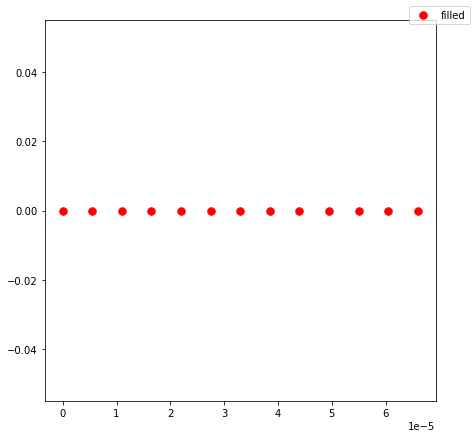

In [2]:
register = AtomArrangement()
separation = 5.5e-6  # in meters 
num_atoms = 13 # 4n+1

for k in range(num_atoms):
    register.add((k*separation, 0))
    
show_register(register)

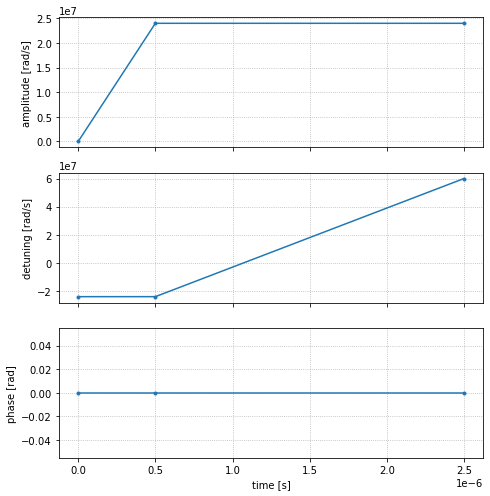

In [3]:
# Build the time values for the driving fields
duration = 3e-6
time_ramp = 5e-7

amplitude_min = 0       
amplitude_max = 24e6
detuning_min = -24e6
detuning_max = 60e6

time_points = [0, time_ramp, duration-time_ramp]
amplitude_values = [amplitude_min, amplitude_max, amplitude_max]
detuning_values = [detuning_min, detuning_min, detuning_max]
phase_values = [0, 0, 0]

drive_initial = get_drive(time_points, amplitude_values, detuning_values, phase_values)

show_global_drive(drive_initial)

10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.04s. Est. time left: 00:00:00:00
30.0%. Run time:   0.07s. Est. time left: 00:00:00:00
40.0%. Run time:   0.10s. Est. time left: 00:00:00:00
50.0%. Run time:   0.13s. Est. time left: 00:00:00:00
60.0%. Run time:   0.17s. Est. time left: 00:00:00:00
70.0%. Run time:   0.21s. Est. time left: 00:00:00:00
80.0%. Run time:   0.26s. Est. time left: 00:00:00:00
90.0%. Run time:   0.31s. Est. time left: 00:00:00:00
Total run time:   0.36s


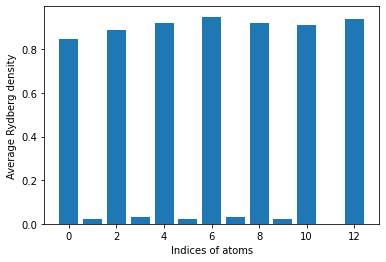

In [5]:
ahs_program_initial = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive_initial
)


result = device.run(ahs_program_initial, blockade_radius=separation, progress_bar=True, shots=100).result()
show_final_avg_density(result)

## $Z_2$ order phase with a defect

In [6]:
# Build the time values for the driving and shifting fields
shift_value = -1.5*detuning_max
max_shift_slew_rate = 1250000000000000
time_ramp_shift = abs(shift_value)/max_shift_slew_rate

max_amplitude_slew_rate = 2.5e14
time_ramp_down_amplitude = (amplitude_max-amplitude_min)/max_amplitude_slew_rate

times_defect_creation = [0, time_ramp_shift, time_ramp_shift+time_ramp_down_amplitude]

values_amplitude_defect = [amplitude_values[-1], amplitude_max, amplitude_min]
values_detuning_defect = [detuning_values[-1], detuning_max, detuning_max]
values_phase_defect = [0, 0, 0]

drive_defect_creation = get_drive(times_defect_creation, values_amplitude_defect, values_detuning_defect, values_phase_defect)

drive_defect = concatenate_drive_list([drive_initial, drive_defect_creation])

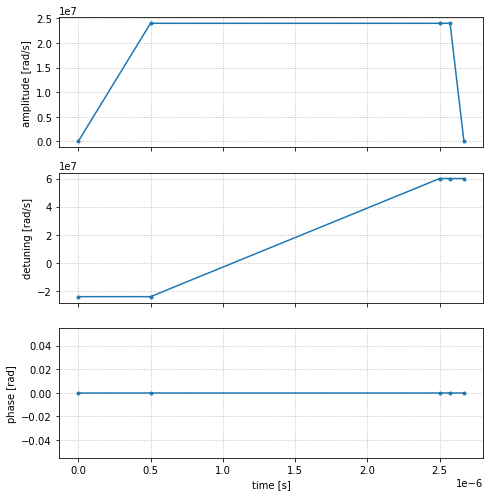

In [7]:
show_global_drive(drive_defect)

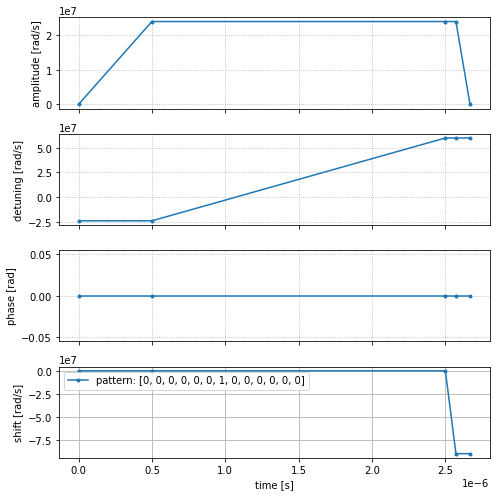

In [8]:
values_magnitude = [0, shift_value, shift_value]
pattern_defect = [1 if idx==int(num_atoms/2) else 0 for idx in range(num_atoms)]

shift_initial = get_shift(time_points, [0 for t in time_points], pattern_defect)
shift_defect_creation = get_shift(times_defect_creation, values_magnitude, pattern_defect)
shift_defect = concatenate_shift_list([shift_initial, shift_defect_creation])

show_drive_and_shift(drive_defect, shift_defect)        

/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:12: UserWarning: Value 3 (-90000000.0) in magnitude sequence outside the typical range [0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(


10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.0%. Run time:   0.04s. Est. time left: 00:00:00:00
30.0%. Run time:   0.07s. Est. time left: 00:00:00:00
40.0%. Run time:   0.11s. Est. time left: 00:00:00:00
50.0%. Run time:   0.15s. Est. time left: 00:00:00:00
60.0%. Run time:   0.19s. Est. time left: 00:00:00:00
70.0%. Run time:   0.24s. Est. time left: 00:00:00:00
80.0%. Run time:   0.29s. Est. time left: 00:00:00:00
90.0%. Run time:   0.35s. Est. time left: 00:00:00:00
Total run time:   0.40s


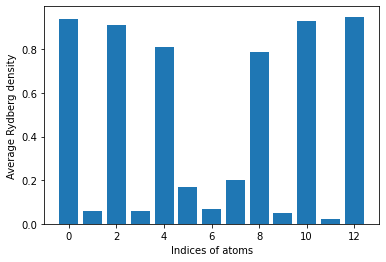

In [9]:
ahs_program_with_defect = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive_defect+shift_defect
)

result = device.run(ahs_program_with_defect, blockade_radius=separation, progress_bar=True, shots=100).result()

show_final_avg_density(result)

## Propagation of particle-antiparticle pairs

In [10]:
max_detuning_slew_rate = 2.5e15
max_duration=4e-6
max_amplitude_slew_rate = 2.5e14
detuning_propagation = -np.pi * 1e6
time_ramp_detuning = abs(detuning_propagation-detuning_max)/max_detuning_slew_rate
time_ramp_amplitude = (amplitude_max-amplitude_min)/max_amplitude_slew_rate

In [11]:
def get_program_propagation(time_propagation):
    
    # Build the time values for the amplitude and phase

    times_propagation_amplitude = [0,
        time_ramp_amplitude,
        time_ramp_amplitude + time_propagation,
        time_propagation + 2*time_ramp_amplitude
    ]

    # build the waveform for the amplitude and phase
    values_amplitude_propagation = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
    values_phase_propagation = [0, 0, 0, 0]    
    
    amplitude = TimeSeries()
    phase = TimeSeries()    
    for t, v_1, v_2 in zip(times_propagation_amplitude, values_amplitude_propagation, values_phase_propagation):
        amplitude.put(t, v_1)
        phase.put(t, v_2)

    
    # Build the time values for the detuning
    times_propagation_detuning = [0, time_ramp_detuning, times_propagation_amplitude[-1]]


    # build the waveform for the detuning
    values_detuning_propagation = [detuning_max, detuning_propagation, detuning_propagation]

    detuning = TimeSeries()
    for t, v in zip(times_propagation_detuning, values_detuning_propagation):
        detuning.put(t, v)    
        
    drive_propagation = concatenate_drive_list(
        [
            drive_defect, 
            DrivingField(amplitude=amplitude, detuning=detuning, phase=phase)    
        ]
    )
    
    
    # Build the time values for the shifting fields
    times_propagation_shift = [0, time_ramp_shift, times_propagation_amplitude[-1]]

    values_magnitude_propagation = [shift_defect.magnitude.time_series.values()[-1], 0, 0]

    magnitude = TimeSeries()
    for t, v in zip(times_propagation_shift, values_magnitude_propagation):
        magnitude.put(t, v)

    shift_propagation = concatenate_shift_list(
        [
            shift_defect, 
            ShiftingField(Field(time_series=magnitude, pattern=Pattern(pattern_defect)))
        ]
    )


    ahs_program_propagation = AnalogHamiltonianSimulation(
        register=register, 
        hamiltonian=drive_propagation+shift_propagation
    )
    return drive_propagation, shift_propagation, ahs_program_propagation    
    

In [12]:
max_time_propagation = max_duration - ahs_program_with_defect.hamiltonian.terms[0].amplitude.time_series.times()[-1] - time_ramp_detuning - time_ramp_amplitude
drive_propagation, shift_propagation, _ = get_program_propagation(max_time_propagation)


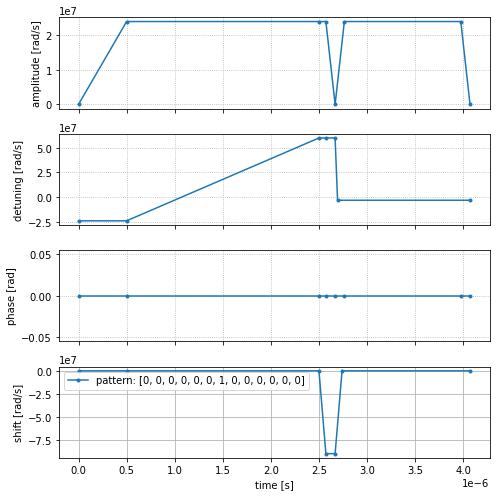

In [13]:
show_drive_and_shift(drive_propagation, shift_propagation)

In [14]:
def get_average_densities_propagation(max_time_propagation, time_steps=100, simulation_steps=100):
    time_propagation_list = np.linspace(0, max_time_propagation, num=time_steps)
    
    ahs_program_propagation_list = [get_program_propagation(time_propagation)[2] for time_propagation in time_propagation_list]
    
    result_list = [device.run(ahs_program_propagation, blockade_radius=separation, steps=simulation_steps, shots=100).result() 
                   for ahs_program_propagation in ahs_program_propagation_list]
    
    average_densities = [get_avg_density(result) for result in result_list]
    
    return average_densities
        

In [ ]:
densities = get_average_densities_propagation(max_time_propagation)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(densities))